## Graph
We will define a graph as a tuple $G=(V,E,\mathbf{u})$.

*   $V$ is a set of node features  $V=\{\mathbf{v}_i\}_{i=1:N^v}$, where $\mathbf{v}_i$ is the feature vector of node $v_i$ and $N^v$ is the number of nodes (Note: The use of $v$ comes from the term "**vertex**" which can be used interchangeably with the term "node"). 
*   $E$ is a set of edges  $E=\{(r_k, s_k)\}_{k=1:N^e}$ where $r_k$ is the index of the target (or receiver) node, $s_k$ is the index of the source node, and $N^e$ is the number of edges. Note that another common convention is to define edges as  $E=\{(s_k, r_k)\}_{k=1:N^e}$.

 If the edges have features, then $E$ can be written as $E=\{(\mathbf{e}_k, r_k, s_k)\}_{k=1:N^e}$  where $\mathbf{e}_k$ is the feature vector of edge $k$. 

*   $\mathbf{u}$ is the feature vector of the graph.

# Pytorch Geometric 

Pytorch geometric (**PyG**) is an extension library for **Pytorch** which facilitates learning on datasets that are represented by graphs, and provides:

* Common [convolutional operators](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html) on graphs.
* Common benchmark [graph datasets](https://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html).
* Operations on graphs.


In [21]:
! python -c "import torch; print(torch.__version__)"

1.7.0+cu101


In [2]:
!pip install -q torch-scatter -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-sparse -f https://pytorch-geometric.com/whl/torch-1.7.0+cu101.html
!pip install -q torch-geometric

     |████████████████████████████████| 11.9MB 16.5MB/s 
     |████████████████████████████████| 24.3MB 107kB/s 
     |████████████████████████████████| 194kB 18.0MB/s 
     |████████████████████████████████| 235kB 40.5MB/s 
     |████████████████████████████████| 2.2MB 55.4MB/s 
     |████████████████████████████████| 51kB 7.6MB/s 


A graph in PyG is described by an instance of the [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data) class.


The edges in a directed graph are represented by an edge list `Data.edge_index`, which is a `torch.tensor` of size ($2 \times N^e$). The first row of `Data.edge_index` contains the indices of the source vertices of each edge, and the second row of `Data.edge_index` contains the indices of the target indices. __Note that all edges are directed in PyG__. To represent an undirected graph, both directions of the edge should be included in Data.edge_index.

A graph may also have a node feature tensor `Data.x` of size ($N^v \times N^{f_{nodes}}$), where $N^{f_{nodes}}$ is the number of features of each node.

 In addition to the `edge_index` and `x` attributes, an instance of `torch_geometric.data.Data` may contain other attributes such as
 
   * the labels of each node (for supervised learning tasks),
   * boolean masks which specify the nodes in a training - validation - testing split, 
   * edge features (analogous to node features). Typically stored in PyG as `Data.edge_attr` and should be of size ($N^e \times N^{f_{edges}}$), where $N^{f_{edges}}$ is the number of features of each edge,
   *  node-type and edge-type (for heterogeneous graphs). 

In order for these attributes to be useful, their dimensions have to be consistent with the number of nodes and number of edges implied by `edge_index`




In [5]:
import torch
from torch_geometric.data import Data

In [18]:
# edge_index of size 2x6 corresponding to 6 edges
edge_index = torch.tensor([
                           
                           [0, 1, 1, 2, 4, 3, 5, 5, 5], # source nodes
                           [1, 0, 2, 3, 3, 1, 3, 2, 4]  # target nodes
                           ],dtype=torch.long)

edge_index

tensor([[0, 1, 1, 2, 4, 3, 5, 5, 5],
        [1, 0, 2, 3, 3, 1, 3, 2, 4]])

In [23]:
# feature matrix that stores the features of the nodes of size 5x2
x = torch.tensor([[-1, 0],
                  [ 0, 1],
                  [ 1,-1],
                  [-1, 0],
                  [ 0, 1],
                  [0, 1]], dtype=torch.float)

x

tensor([[-1.,  0.],
        [ 0.,  1.],
        [ 1., -1.],
        [-1.,  0.],
        [ 0.,  1.],
        [ 0.,  1.]])

In [30]:
# feature matrix that stores the features of the edges of size 6x1
edge_attr = torch.tensor([[170.],
                          [200.],
                          [120.],
                          [100.],
                          [230.],
                          [100.],
                          [100.],
                          [200.],
                          [300.]], dtype=torch.float)

edge_attr

tensor([[170.],
        [200.],
        [120.],
        [100.],
        [230.],
        [100.],
        [100.],
        [200.],
        [300.]])

In [31]:
# Initialize a Data object
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
data

Data(edge_attr=[9, 1], edge_index=[2, 9], x=[6, 2])

In [32]:
print("Number of nodes: ",data.num_nodes)
print("Number of edges:",data.num_edges)
print("Is this an undirected graph?",data.is_undirected())
print("Number of features per node (length of feature vector)",data.num_node_features,"\n")
print("Number of features per edge (length of feature vector)",data.num_edge_features,"\n")

Number of nodes:  6
Number of edges: 9
Is this an undirected graph? tensor(False)
Number of features per node (length of feature vector) 2 

Number of features per edge (length of feature vector) 1 



You can visualize the graph using NetworkX

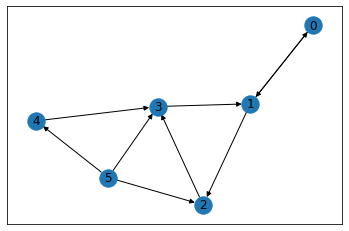

In [33]:
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

G = to_networkx(data)
nx.draw_networkx( G=G )

Let's explore some of the datasets which PyG provides convenient access to. We will first look at [PubMed Diabetes](https://linqs.soe.ucsc.edu/data) citation network dataset.

Each node in the PubMed graph represents a publication pertaining to diabetes and each publication is classifed into one of three categories: "Diabetes Mellitus, Experimental", "Diabetes Mellitus Type 1", "Diabetes Mellitus Type 2".

In addition, each node contains a feature vector which is a [TF/IDF](https://en.wikipedia.org/wiki/Tf%E2%80%93idf) weighted word vector from a dictionary of 500 unique words. 

In [13]:
from torch_geometric.datasets import Planetoid

In [15]:
dataset_pubmed = Planetoid(root="./tmp", name="PubMed")

Processing...
Done!


In [16]:
print("Name of dataset", dataset_pubmed.name)
print("Number of graphs", dataset_pubmed.len())
print("Number of node features per node in a graph", dataset_pubmed.num_node_features)
print("Number of edge features per edge in a graph", dataset_pubmed.num_edge_features)
print("Number of possible node classes", dataset_pubmed.num_classes)

Name of dataset PubMed
Number of graphs 1
Number of node features per node in a graph 500
Number of edge features per edge in a graph 0
Number of possible node classes 3


The graphs in a dataset can be accessed by simply indexing the dataset and are represented by an instance of [`torch_geometric.data.Data`](https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html#torch_geometric.data.Data). In the PubMed dataset there is only one graph, which can be  accessed as follows

In [34]:
graph_pubmed = dataset_pubmed[0]
print(graph_pubmed)

Data(edge_index=[2, 88648], test_mask=[19717], train_mask=[19717], val_mask=[19717], x=[19717, 500], y=[19717])


The fields available in a PyG graph can be accessed using the `keys` attribute

In [37]:
graph_pubmed.keys 

['x', 'edge_index', 'y', 'train_mask', 'val_mask', 'test_mask']

In [38]:
print("Number of nodes: ",graph_pubmed.num_nodes)
print("Is this an undirected graph?",graph_pubmed.is_undirected())
print("Number of edges (Note: divide by 2 to get number of undirected edges): ",graph_pubmed.num_edges)
print("Unique labels of the nodes: ", graph_pubmed.y.unique())
print("Number of features per node (length of feature vector)",graph_pubmed.num_node_features,"\n")
print("Edge Index representation: \n", graph_pubmed.edge_index,"\n")
print("Example of Node feature (first 50 features only): \n", graph_pubmed.x[0][:50], "\n") 
print("Train mask (first 100 entries only): \n", graph_pubmed.train_mask[:100]) 
print("Labels of training nodes: \n", graph_pubmed.y[graph_pubmed.train_mask] ) 
print("Labels of validation nodes (first 100 entries only): \n", graph_pubmed.y[graph_pubmed.val_mask][:100] ) 
print("Labels of testing nodes (first 100 entries only): \n", graph_pubmed.y[graph_pubmed.test_mask][:100] ) 


Number of nodes:  19717
Is this an undirected graph? True
Number of edges (Note: divide by 2 to get number of undirected edges):  88648
Unique labels of the nodes:  tensor([0, 1, 2])
Number of features per node (length of feature vector) 500 

Edge Index representation: 
 tensor([[    0,     0,     0,  ..., 19714, 19715, 19716],
        [ 1378,  1544,  6092,  ..., 12278,  4284, 16030]]) 

Example of Node feature (first 50 features only): 
 tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0050, 0.0000,
        0.0000, 0.0000, 0.0480, 0.0000, 0.0130, 0.0172, 0.0000, 0.0176, 0.0000,
        0.0101, 0.0262, 0.0000, 0.0000, 0.0127, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0208, 0.0000, 0.0000, 0.0155, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0216, 0.0171, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0194]) 

Train mask (first 100 entries only): 
 tensor([ True,  True,  True,  True,  True,  True,  True,  True,  T

PyG comes with utilities to convert *Data* objects to [networkx](https://networkx.github.io/) graphs. This is often useful if you want to run some graph analysis since *Networkx* provides a lot of graph analysis [functions and algorithms](https://networkx.github.io/documentation/stable/reference/index.html). Additionally the *networkx* package provides many vizualisation tools.


In [39]:
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

graph_pubmed_nx = to_networkx(graph_pubmed)


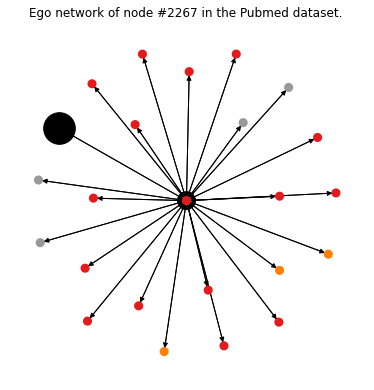

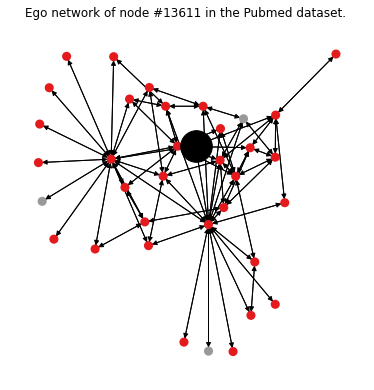

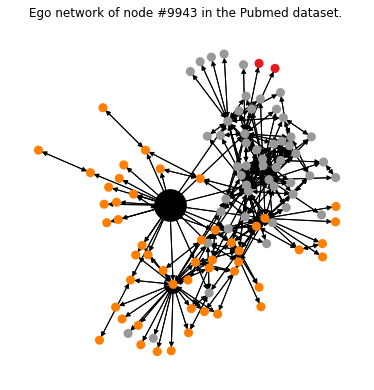

In [40]:
from torch_geometric.utils.convert import to_networkx
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np

# Convert the class label of the nodes from pytorch to numpy format 
node_labels = graph_pubmed.y.numpy()

# Convert the pubmed graph grom PyG format to NetworkX format
graph_pubmed_nx = to_networkx(graph_pubmed)#.to_undirected()

# Plot 3 random subgraphs
for i in range(3):

  # Pick a random node id
  node_id = np.random.randint(graph_pubmed.num_nodes)

  # Create an ego graph of radius 2 around that node
  graph_pubmed_nx_ego = nx.ego_graph(graph_pubmed_nx, node_id,
                                     radius=2, undirected=True)
  
  # Get the class labels of the nodes in the ego graph
  node_labels_ego=node_labels[graph_pubmed_nx_ego.nodes()]

  plt.figure(1,figsize=(5,5)) 

  # Compute the position of each node for the purpose of plotting
  pos = nx.spring_layout(graph_pubmed_nx_ego)
  
  # Draw the ego graph
  nx.draw(graph_pubmed_nx_ego, pos=pos, cmap=plt.get_cmap('Set1'),
          node_color = node_labels_ego, node_size=50,linewidths=2)

  # Draw the the randomly chosen node alone using a bigger size
  nx.draw_networkx_nodes(graph_pubmed_nx_ego,  cmap=plt.get_cmap('Set1'), pos=pos,
                        nodelist=[node_id], node_size=1000,  node_color = "black")
  
  plt.title("Ego network of node #{} in the Pubmed dataset. ".format(node_id))
  plt.show()


In [53]:
def visualize(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])

    if torch.is_tensor(h):
        h = h.detach().cpu().numpy()
        plt.scatter(h[:, 0], h[:, 1], s=140, c=color, cmap="Set2")
        if epoch is not None and loss is not None:
            plt.xlabel(f'Epoch: {epoch}, Loss: {loss.item():.4f}', fontsize=16)
    else:
        nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False,
                         node_color=color, cmap="Set2")
    plt.show()

In [42]:
from torch_geometric.datasets import KarateClub

dataset = KarateClub()
print(f'Dataset: {dataset}:')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features: 34
Number of classes: 4


In [43]:
data = dataset[0]  # Get the first graph object.

print(data)
print('==============================================================')

# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Data(edge_index=[2, 156], train_mask=[34], x=[34, 34], y=[34])
Number of nodes: 34
Number of edges: 156
Average node degree: 4.59
Number of training nodes: 4
Training node label rate: 0.12
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


In [47]:
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))

edge_index = data.edge_index
print(edge_index.t())

<IPython.core.display.Javascript object>

tensor([[ 0,  1],
        [ 0,  2],
        [ 0,  3],
        [ 0,  4],
        [ 0,  5],
        [ 0,  6],
        [ 0,  7],
        [ 0,  8],
        [ 0, 10],
        [ 0, 11],
        [ 0, 12],
        [ 0, 13],
        [ 0, 17],
        [ 0, 19],
        [ 0, 21],
        [ 0, 31],
        [ 1,  0],
        [ 1,  2],
        [ 1,  3],
        [ 1,  7],
        [ 1, 13],
        [ 1, 17],
        [ 1, 19],
        [ 1, 21],
        [ 1, 30],
        [ 2,  0],
        [ 2,  1],
        [ 2,  3],
        [ 2,  7],
        [ 2,  8],
        [ 2,  9],
        [ 2, 13],
        [ 2, 27],
        [ 2, 28],
        [ 2, 32],
        [ 3,  0],
        [ 3,  1],
        [ 3,  2],
        [ 3,  7],
        [ 3, 12],
        [ 3, 13],
        [ 4,  0],
        [ 4,  6],
        [ 4, 10],
        [ 5,  0],
        [ 5,  6],
        [ 5, 10],
        [ 5, 16],
        [ 6,  0],
        [ 6,  4],
        [ 6,  5],
        [ 6, 16],
        [ 7,  0],
        [ 7,  1],
        [ 7,  2],
        [ 

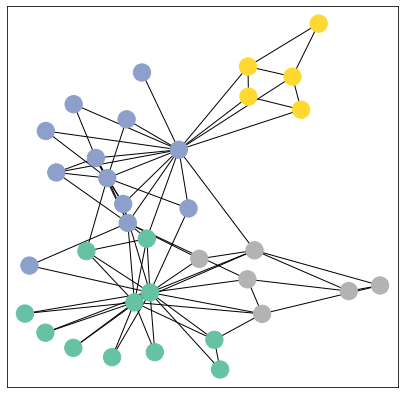

In [48]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
visualize(G, color=data.y)

## Implementing Graph Neural Networks

**GCN layer** ([Kipf et al. (2017)](https://arxiv.org/abs/1609.02907)), which is defined as

$$
\mathbf{x}_v^{(\ell + 1)} = \mathbf{W}^{(\ell + 1)} \sum_{w \in \mathcal{N}(v) \, \cup \, \{ v \}} \frac{1}{c_{w,v}} \cdot \mathbf{x}_w^{(\ell)}
$$

where $\mathbf{W}^{(\ell + 1)}$ denotes a trainable weight matrix of shape `[num_output_features, num_input_features]` and $c_{w,v}$ refers to a fixed normalization coefficient for each edge.

PyG implements this layer via [`GCNConv`](https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv), which can be executed by passing in the node feature representation `x` and the COO graph connectivity representation `edge_index`.

With this, we are ready to create our first Graph Neural Network by defining our network architecture in a `torch.nn.Module` class:

In [44]:
import torch 
from torch.nn import Linear
from torch_geometric.nn import GCNConv

The graph convolutional operator from the "Semi-supervised
Classification with Graph Convolutional Networks"
<https://arxiv.org/abs/1609.02907>_ paper

- https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html#torch_geometric.nn.conv.GCNConv


In [45]:
class GCN(torch.nn.Module):
    def __init__(self):
        super(GCN, self).__init__()
        torch.manual_seed(12345) # Sets the seed for generating random numbers. Returns a torch.Generator object.
        self.conv1 = GCNConv(dataset.num_features, 4)
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.classifier = Linear(2, dataset.num_classes)
    
    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        h = h.tanh() #Final GNN Embedding Space

        #Apply a final linear classifier
        out = self.classifier(h)

        return out, h

In [46]:
model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (classifier): Linear(in_features=2, out_features=4, bias=True)
)


Here, we first initialize all of our building blocks in `__init__` and define the computation flow of our network in `forward`.
We first define and stack **three graph convolution layers**, which corresponds to aggregating 3-hop neighborhood information around each node (all nodes up to 3 "hops" away).
In addition, the `GCNConv` layers reduce the node feature dimensionality to $2$, *i.e.*, $34 \rightarrow 4 \rightarrow 4 \rightarrow 2$. Each `GCNConv` layer is enhanced by a [tanh](https://pytorch.org/docs/stable/generated/torch.nn.Tanh.html?highlight=tanh#torch.nn.Tanh) non-linearity.

After that, we apply a single linear transformation ([`torch.nn.Linear`](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html?highlight=linear#torch.nn.Linear)) that acts as a classifier to map our nodes to 1 out of the 4 classes/communities.

We return both the output of the final classifier as well as the final node embeddings produced by our GNN.
We proceed to initialize our final model via `GCN()`, and printing our model produces a summary of all its used sub-modules.


### Embedding the Karate Club Network

Let's take a look at the node embeddings produced by our GNN.
Here, we pass in the initial node features `x` and the graph connectivity information `edge_index` to the model, and visualize its 2-dimensional embedding.

Embedding shape: [34, 2]


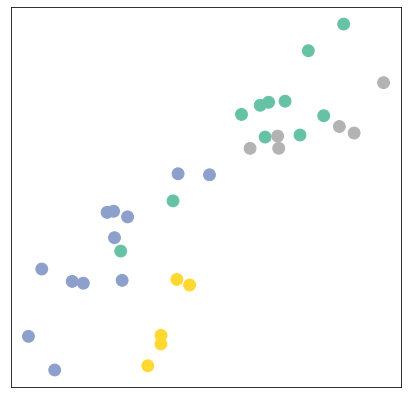

In [54]:
model = GCN()

_, h = model(data.x, data.edge_index)
print(f'Embedding shape: {list(h.shape)}')

visualize(h, color=data.y)

Remarkably, even before training the weights of our model, the model produces an embedding of nodes that closely resembles the community-structure of the graph.
Nodes of the same color (community) are already closely clustered together in the embedding space, although the weights of our model are initialized **completely at random** and we have not yet performed any training so far!
This leads to the conclusion that GNNs introduce a strong inductive bias, leading to similar embeddings for nodes that are close to each other in the input graph.

### Training on the Karate Club Network

But can we do better? Let's look at an example on how to train our network parameters based on the knowledge of the community assignments of 4 nodes in the graph (one for each community):

Since everything in our model is differentiable and parameterized, we can add some labels, train the model and observse how the embeddings react.
Here, we make use of a semi-supervised or transductive learning procedure: We simply train against one node per class, but are allowed to make use of the complete input graph data.

Training our model is very similar to any other PyTorch model.
In addition to defining our network architecture, we define a loss critertion (here, [`CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)) and initialize a stochastic gradient optimizer (here, [`Adam`](https://pytorch.org/docs/stable/optim.html?highlight=adam#torch.optim.Adam)).
After that, we perform multiple rounds of optimization, where each round consists of a forward and backward pass to compute the gradients of our model parameters w.r.t. to the loss derived from the forward pass.
If you are not new to PyTorch, this scheme should appear familar to you. 
Otherwise, the PyTorch docs provide [a good introduction on how to train a neural network in PyTorch](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html#define-a-loss-function-and-optimizer).

Note that our semi-supervised learning scenario is achieved by the following line:
```
loss = criterion(out[data.train_mask], data.y[data.train_mask])
```
While we compute node embeddings for all of our nodes, we **only make use of the training nodes for computing the loss**.
Here, this is implemented by filtering the output of the classifier `out` and ground-truth labels `data.y` to only contain the nodes in the `train_mask`.

Let us now start training and see how our node embeddings evolve over time (best experienced by explicitely running the code):

<IPython.core.display.Javascript object>

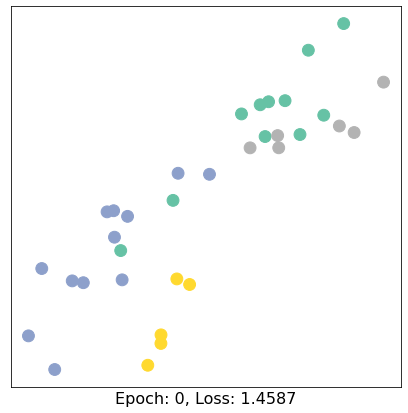

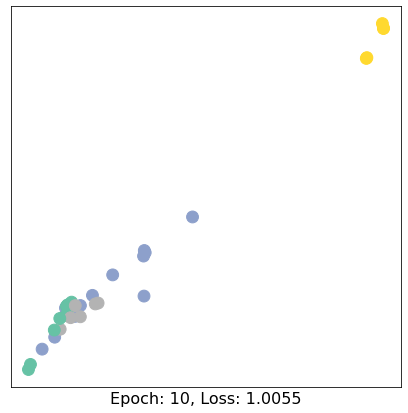

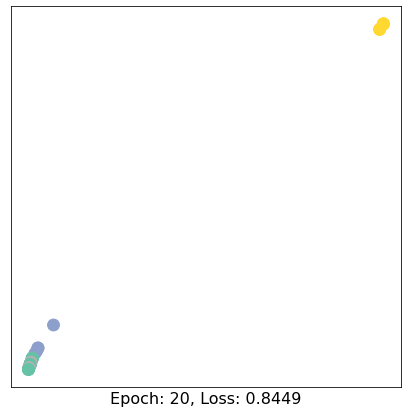

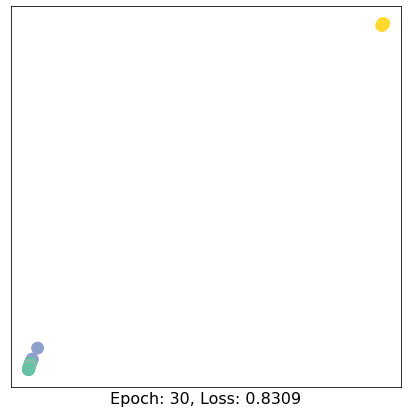

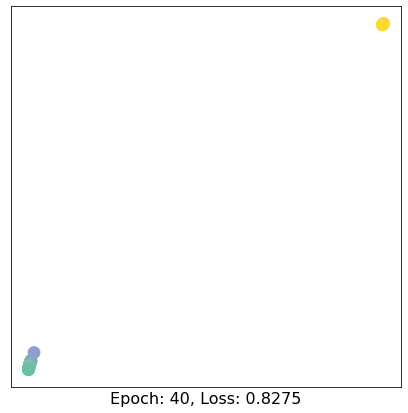

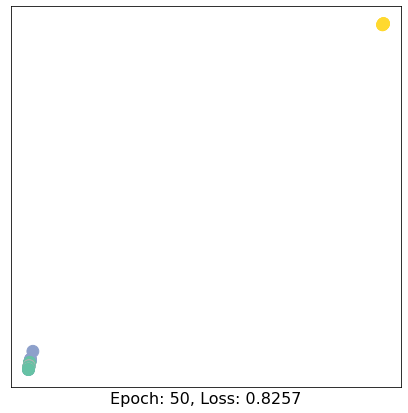

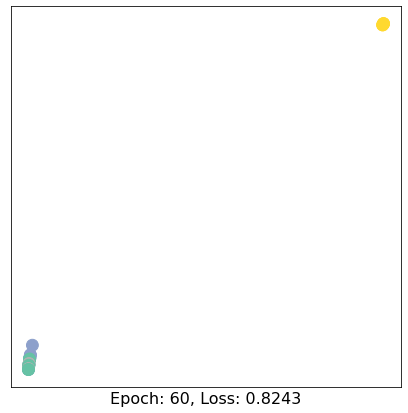

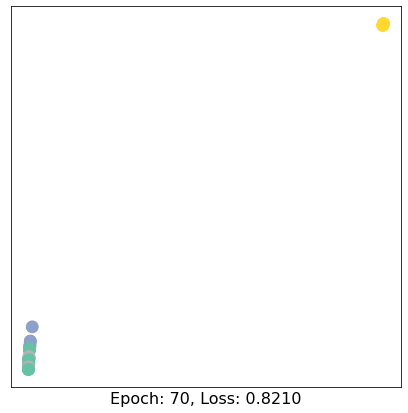

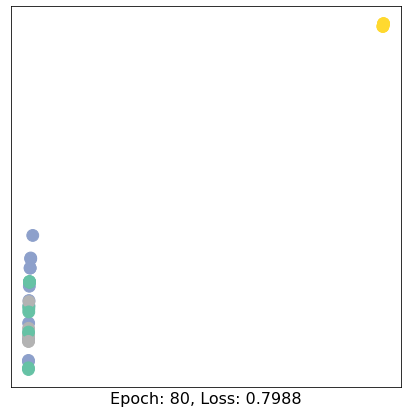

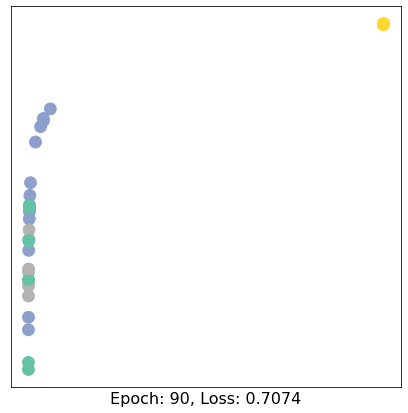

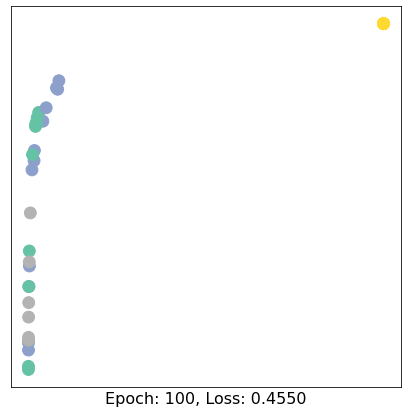

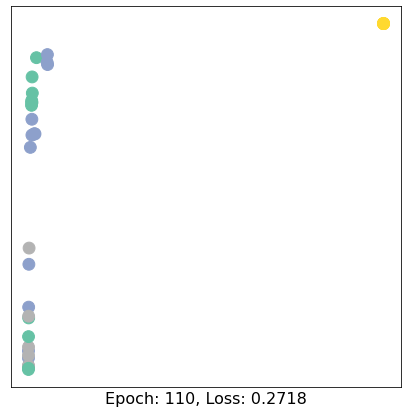

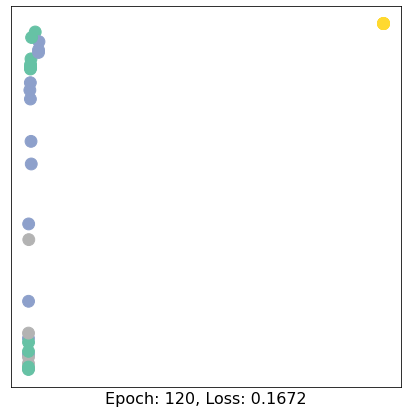

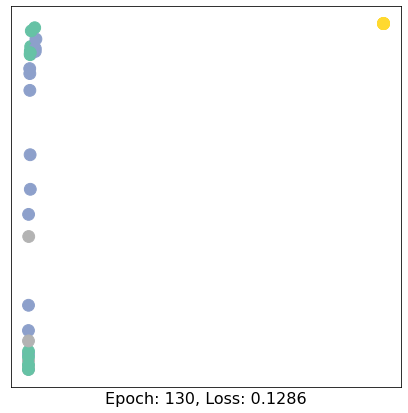

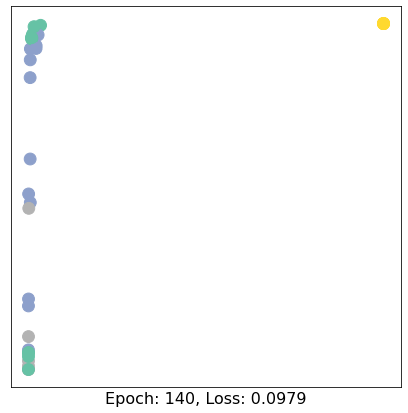

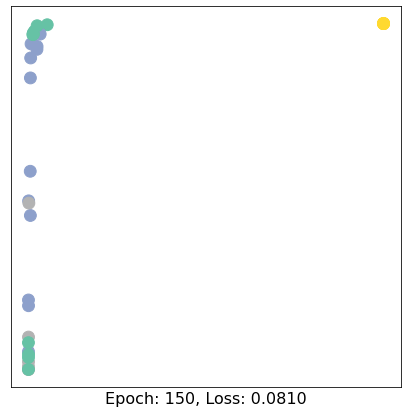

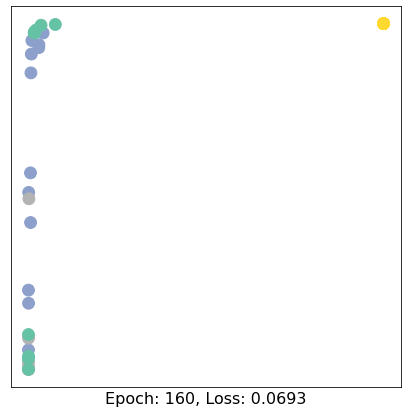

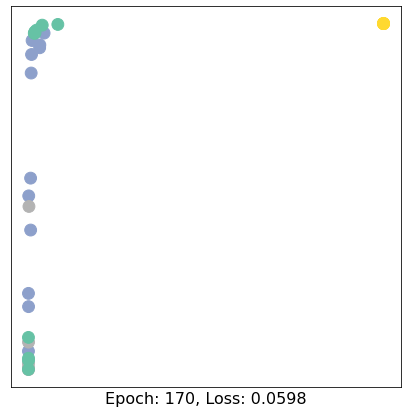

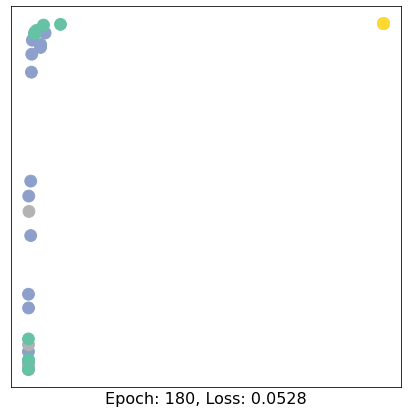

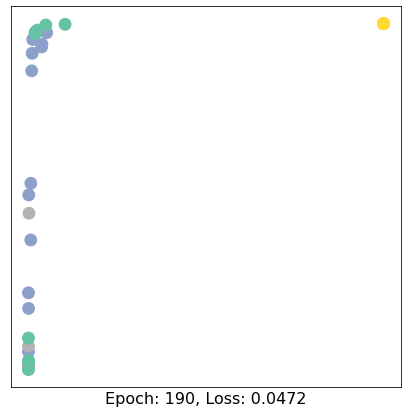

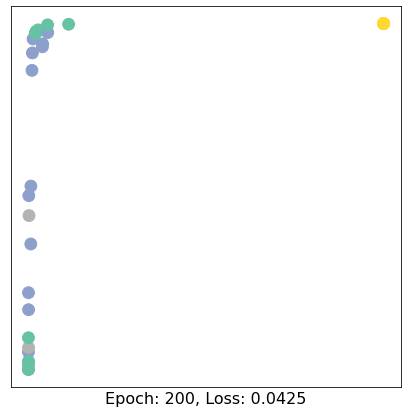

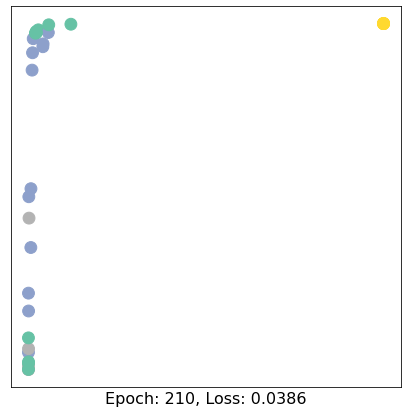

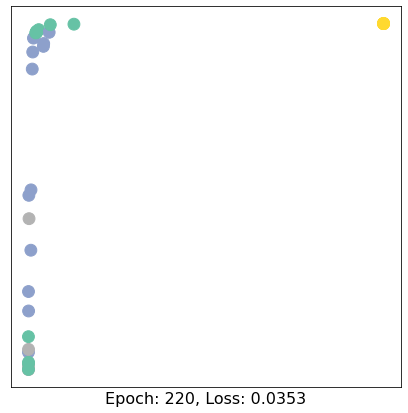

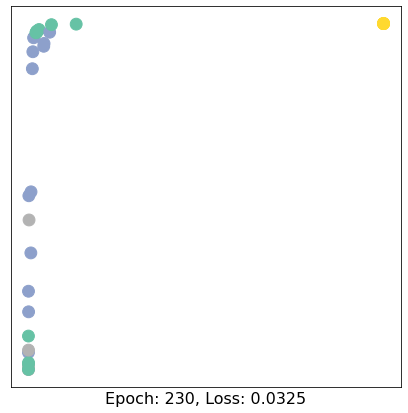

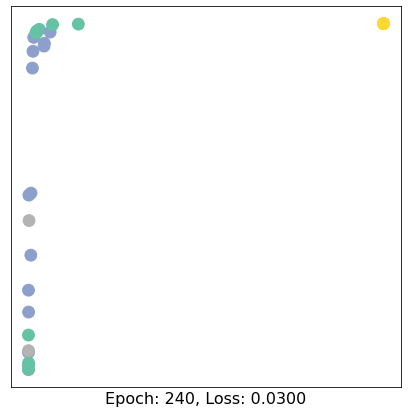

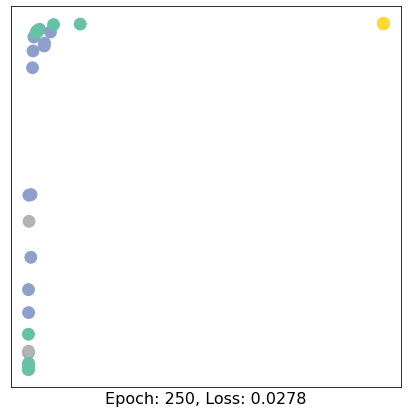

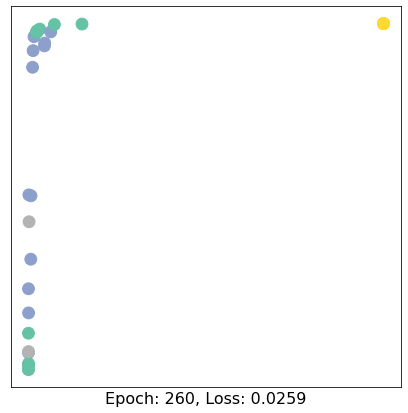

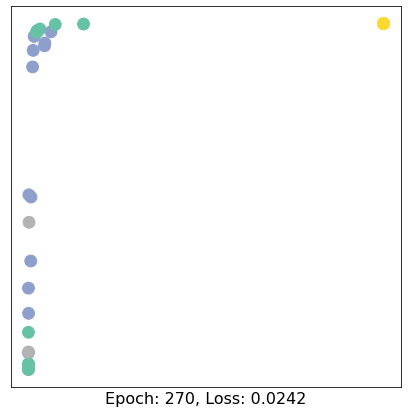

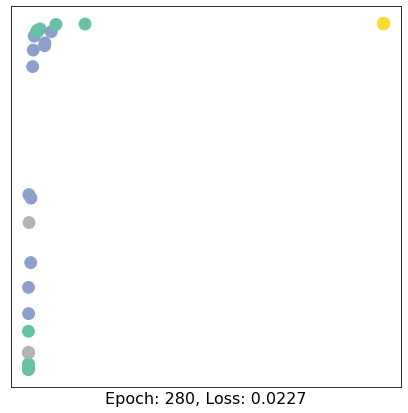

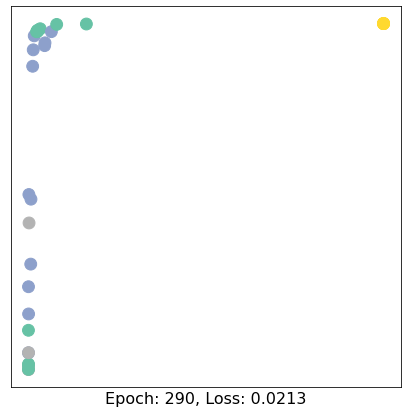

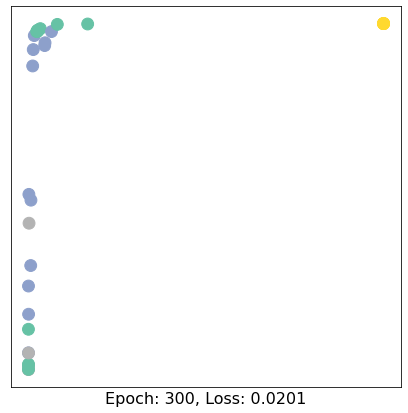

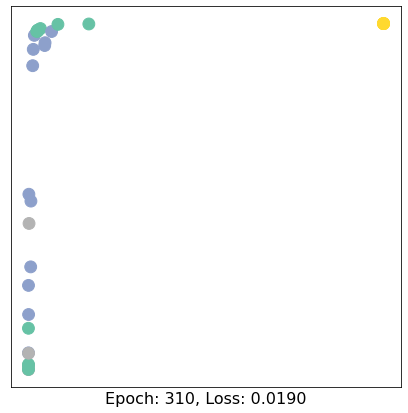

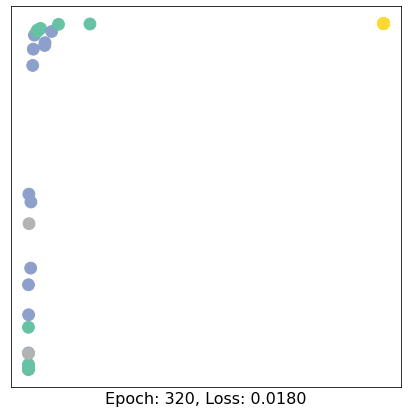

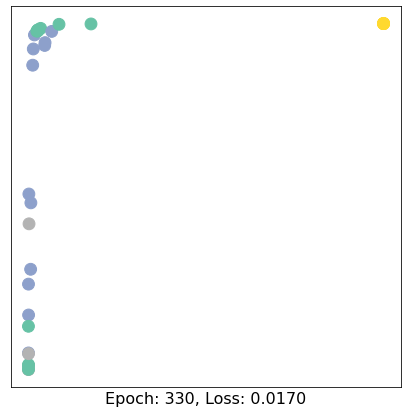

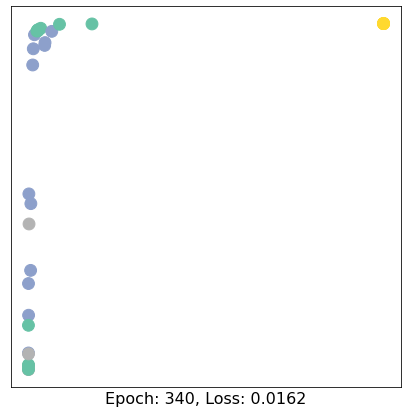

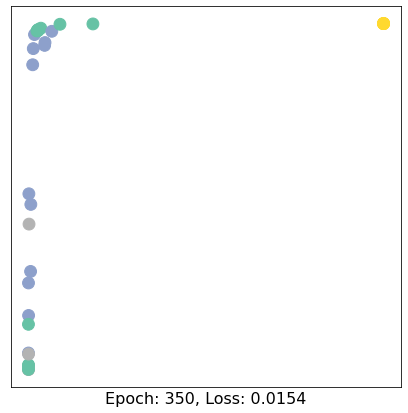

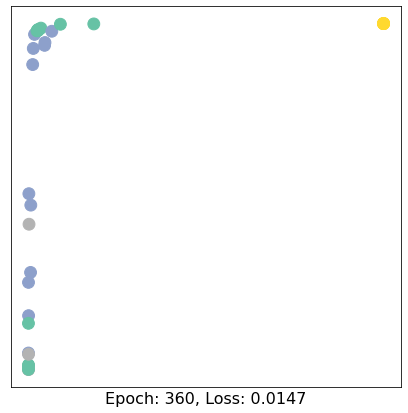

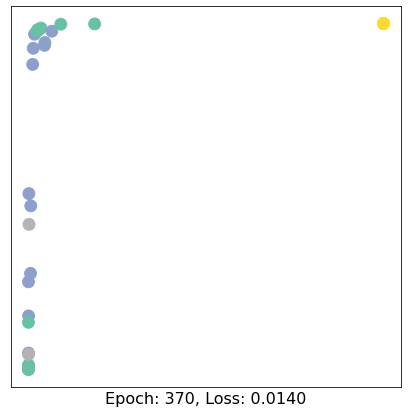

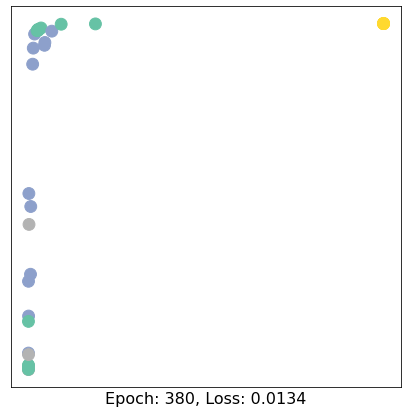

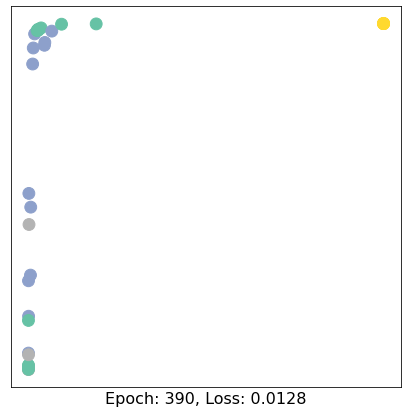

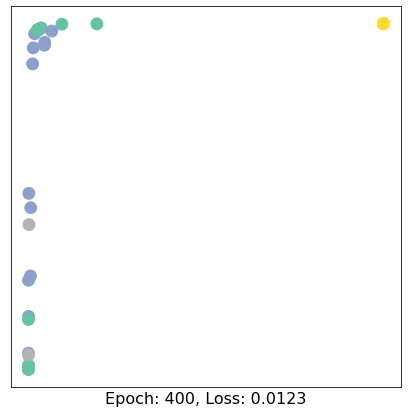

In [61]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 430})'''))

model = GCN()
criterion = torch.nn.CrossEntropyLoss()  # Define loss criterion.
optimizer = torch.optim.Adam(model.parameters(), lr=0.05)  # Define optimizer.

def train(data):
    optimizer.zero_grad()  # Clear gradients.
    out, h = model(data.x, data.edge_index)  # Perform a single forward pass.
    loss = criterion(out[data.train_mask], data.y[data.train_mask])  # Compute the loss solely based on the training nodes.
    loss.backward()  # Derive gradients.
    optimizer.step()  # Update parameters based on gradients.
    return loss, h

for epoch in range(401):
    loss, h = train(data)
    if epoch % 10 == 0:
        visualize(h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)